In [1]:
import jax

jax.config.update("jax_compilation_cache_dir", "cluster/scratch/mpundir/jax-cache")
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
import numpy as np
import functools
from jax.typing import ArrayLike
from jax import Array

In [2]:
import matplotlib.pyplot as plt
from skimage.morphology import disk, rectangle
import itertools

In [3]:
import matplotlib.pyplot as plt

In [5]:
import sys

sys.path.append("../fft_helpers/")

import tensor_operators as tens
from fd_decorators import (
    compute_perturb_deformation_gradient,
    finite_difference,
    finite_difference_grid,
)
from projection_operators import compute_Ghat_4_2

sys.path.append("../plot_helpers/")
plt.style.use(["../plot_helpers/prl_paper.mplstyle"])
from plot_helper_for_paper import plot_contourf, plot_imshow, set_size

## Using finite-difference approach to derive tangent modulii
Here we test hoe much computation time does it take to compute stress and tangent moduluu from a standard implementation and a AD derived implementation. 

We test it for a single pixel point. 

Defining material parameters for the single pixel point. 

In [6]:
ndim = 2

In [7]:
E = 1
nu = 0.3
λ0 = nu * E / ((1 + nu) * (1 - 2 * nu))
μ0 = E / (2 * (1 + nu))
K = λ0 + 2 * μ0 / 3

## using automatic differentiation to compute stress and  tangent modulii from energy functional

In [8]:
@jax.jit
def green_lagrange_strain(F):
    I = jnp.eye(ndim)
    return 0.5 * (jnp.einsum("ij, jk-> ik", F.T, F) - I)


@jax.jit
def strain_energy(F):
    E = green_lagrange_strain(F)
    energy = 0.5 * jnp.multiply(λ0, jnp.einsum("ii->", E) ** 2) + jnp.multiply(
        μ0, jnp.einsum("ii->", jnp.einsum("ij, jk->ik", E, E))
    )
    return energy.sum()


piola_kirchhoff_ad = jax.jit(jax.jacfwd(strain_energy))
tangent_modulii_ad = jax.jit(jax.jacrev(piola_kirchhoff_ad))

## using finite difference to calculate the tangent modulii

Assume that we have a function $f(\boldsymbol{\varepsilon)}\to \boldsymbol{\sigma}$.
The tangent modulii using finite-difference can thus be given as 

$$ C_{ijkl} = \dfrac{\partial \sigma_{ij}}{\partial \varepsilon_{kl}} = \dfrac{P_{ij}(\boldsymbol{F}^{kl}) - P_{ij}(\boldsymbol{F})}{\Delta F_{kl}^{kl}} $$

In [9]:
def tangent_modulii_fd(func, fixed_point, increment):
    fixed_value = func(fixed_point)
    output = np.zeros((ndim, ndim, ndim, ndim))
    for i, j, k, l in itertools.product(range(ndim), repeat=4):
        ΔF_kl = compute_perturb_deformation_gradient(increment, k, l)
        F_kl = fixed_point + ΔF_kl
        output[i, j, k, l] = (func(F_kl)[i, j] - fixed_value[i, j]) / ΔF_kl[k, l]
    return output

Computing and comparing the difference between the automatically derived tangent modulii and numerically approximated tangent modulii. 

In [10]:
F = np.identity(2) + np.array([[1.1, 0.01], [0.1, 0.1]])

In [11]:
tangent_modulii_fd(piola_kirchhoff_ad, fixed_point=F, increment=1e-6)  - tangent_modulii_ad(F)

Array([[[[4.24153689e-06, 1.41298746e-06],
         [1.41346606e-06, 6.05287945e-07]],

        [[6.73734692e-09, 2.01902823e-08],
         [2.84990809e-09, 6.71031022e-09]]],


       [[[6.73761568e-08, 2.88430048e-08],
         [2.02011776e-07, 6.73126152e-08]],

        [[3.17740181e-07, 7.40262418e-07],
         [7.40662880e-07, 2.22089129e-06]]]], dtype=float64)

Now we generalize our finite difference function to act  on  `N x N` points simultaneously.

In [12]:
@finite_difference(increment=1e-6, ndim=2)
def compute_stress(F):
    return piola_kirchhoff_ad(F)

In [13]:
compute_stress(F)

(Array([[4.96181442, 0.11708721],
        [0.29167596, 1.24578558]], dtype=float64),
 array([[[[8.29911001, 0.07057834],
          [0.28692449, 1.33307753]],
 
         [[0.07057693, 2.8242404 ],
          [0.88903846, 0.09557693]]],
 
 
        [[[0.28692314, 0.88903849],
          [2.8413752 , 0.15615391]],
 
         [[1.33307724, 0.09557766],
          [0.15615459, 2.76064645]]]]))

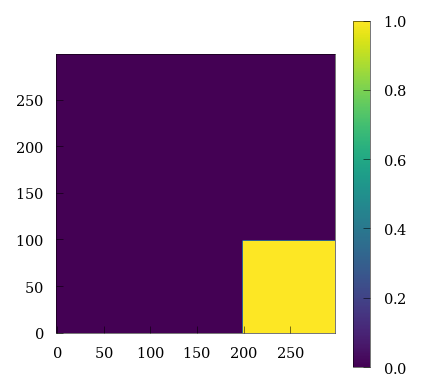

In [14]:
H, L = (299, 299)
Hmid = int(H / 2)
Lmid = int(L / 2)
r = int(H / 3)

structure = np.zeros((H, L))
structure[:r, -r:] += rectangle(r, r)

plt.figure(figsize=(3, 3))
cb = plt.imshow(structure, origin="lower")
plt.colorbar(cb)

In [15]:
ndim = len(structure.shape)
N = structure.shape[0]

# grid dimensions
shape = [N, N]  # number of voxels in all directions

We also define certain Identity tensor for each grid point.

- $\mathbf{I}$ = 2 order Identity tensor with shape `(2, 2, N, N)` 
- $\mathbb{I4}$ = 4 order Identity tensor with shape `(2, 2, 2, 2, N, N)`


In [16]:
# identity tensor (single tensor)
i = jnp.eye(ndim)

# identity tensors (grid)
I = jnp.einsum("ij,xy", i, jnp.ones([N, N]))  # 2nd order Identity tensor
I4 = jnp.einsum(
    "ijkl,xy->ijklxy", jnp.einsum("il,jk", i, i), jnp.ones([N, N])
)  # 4th order Identity tensor
I4rt = jnp.einsum("ijkl,xy->ijklxy", jnp.einsum("ik,jl", i, i), jnp.ones([N, N]))
I4s = (I4 + I4rt) / 2.0

II = tens.dyad22(I, I)

## assigning material parameters 
We assign material parameters to the two phases. The two phases within the RVE are denoted as
- Soft = 0
- Hard = 1

In [17]:
# material parameters + function to convert to grid of scalars
@functools.partial(jax.jit, static_argnames=["soft", "hard"])
def param(X, soft, hard):
    return soft * jnp.ones_like(X) * (X) + hard * jnp.ones_like(X) * (1 - X)

In [18]:
# material parameters
elastic_modulus = {"hard": 5.7, "soft": 0.57}  # N/mm2
poisson_modulus = {"hard": 0.386, "soft": 0.386}

# lames constant
lambda_modulus = {}
shear_modulus = {}
bulk_modulus = {}

for key in elastic_modulus.keys():
    lambda_modulus[key] = (
        poisson_modulus[key]
        * elastic_modulus[key]
        / ((1 + poisson_modulus[key]) * (1 - 2 * poisson_modulus[key]))
    )

    shear_modulus[key] = elastic_modulus[key] / (2 * (1 + poisson_modulus[key]))

    bulk_modulus[key] = lambda_modulus[key] + 2 * shear_modulus[key] / 3

In [19]:
# material parameters
K = param(
    structure, soft=bulk_modulus["soft"], hard=bulk_modulus["hard"]
)  # bulk      modulus
μ0 = param(
    structure, soft=shear_modulus["soft"], hard=shear_modulus["hard"]
)  # shear     modulus
λ0 = param(
    structure, soft=lambda_modulus["soft"], hard=lambda_modulus["hard"]
)  # shear     modulus

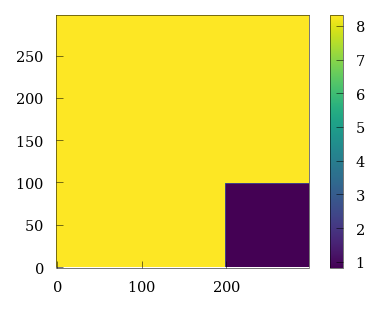

In [20]:
plt.imshow(K, origin="lower")
plt.colorbar()

In [21]:
Ghat4_2 = compute_Ghat_4_2(NN=(N,) * ndim, operator="fourier", length=1.0)

In [22]:
# (inverse) Fourier transform (for each tensor component in each direction)
@jax.jit
def fft(x):
    return jnp.fft.fftshift(jnp.fft.fftn(jnp.fft.ifftshift(x), [N, N]))


@jax.jit
def ifft(x):
    return jnp.fft.fftshift(jnp.fft.ifftn(jnp.fft.ifftshift(x), [N, N]))


# functions for the projection 'G', and the product 'G : K : dF'
@jax.jit
def G(A2):
    return jnp.real(ifft(tens.ddot42(Ghat4_2, fft(A2)))).reshape(-1)

In [23]:
@jax.jit
def green_lagrange_strain(F: ArrayLike) -> Array:
    return 0.5 * (tens.dot22(tens.trans2(F), F) - I)


@jax.jit
def strain_energy(F: ArrayLike) -> Array:
    E = green_lagrange_strain(F)
    E = 0.5 * (E + tens.trans2(E))
    energy = 0.5 * jnp.multiply(λ0, tens.trace2(E) ** 2) + jnp.multiply(
        μ0, tens.trace2(tens.dot22(E, E))
    )
    return energy.sum()


piola_kirchhoff = jax.jit(jax.jacrev(strain_energy))

In [24]:
@finite_difference_grid(increment=1e-8)
def constitutive(F):
    return piola_kirchhoff(F)

@functools.partial(jax.jit, static_argnames=['constitutive'])
def G_P(dF, additional, constitutive):
    dF = dF.reshape(ndim,ndim,N,N)
    K4 = constitutive(additional)
    tangents = jnp.einsum('ijklxy, klxy -> ijxy', K4, dF)
    return G(tangents)


# defining conjugate gradient solver

Here, we define a `conjugate gradient` solver for solving the linear equation

In [25]:
@functools.partial(jax.jit, static_argnames=["A", "K"])
def conjugate_gradient(A, b, additional, K, atol=1e-5):

    b, additional = jax.device_put((b, additional))

    iiter = 0

    def body_fun(state):
        b, p, r, rsold, x, iiter = state
        Ap = A(p, additional, K)
        alpha = rsold / jnp.vdot(p, Ap)
        x = x + jnp.dot(alpha, p)
        r = r - jnp.dot(alpha, Ap)
        rsnew = jnp.vdot(r, r)
        p = r + (rsnew / rsold) * p
        rsold = rsnew
        iiter += 1
        return (b, p, r, rsold, x, iiter)

    def cond_fun(state):
        b, p, r, rsold, x, iiter = state
        return jnp.sqrt(rsold) > atol

    x = jnp.zeros_like(b)
    r = b - A(x, additional, K)

    p = r
    rsold = jnp.vdot(r, r)

    b, p, r, rsold, x, iiter = jax.lax.while_loop(
        cond_fun, body_fun, (b, p, r, rsold, x, iiter)
    )
    return x, iiter

## newton raphson method

Here we define a function to solve the hyperelasticity problem using a `newton-raphson` method

In [26]:
@jax.jit
def solve_netwon_raphson(state, n):
    dF, b, F, Fn, iiter = state

    error = jnp.linalg.norm(dF) / Fn
    jax.debug.print("residual={}", error)

    def true_fun(state):
        dF, b, F, Fn, iiter = state

        dF, iiter_cg = conjugate_gradient(
            atol=1e-8,
            A=G_P,
            b=b,
            additional=F,
            K=constitutive,
        )  # solve linear system using CG

        dF = dF.reshape(ndim, ndim, N, N)

        F = jax.lax.add(F, dF)  # update DOFs (array -> tens.grid)
        P = piola_kirchhoff(F)  # new residual stress
        b = -G(P)  # convert residual stress to residual
        iiter = iiter.at[n, 0].set(iiter_cg)
        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

        return (dF, b, F, Fn, iiter)

    def false_fun(state):
        dF, b, F, Fn, iiter = state

        iiter = iiter.at[n, 1].set(jnp.linalg.norm(dF) / Fn)

        return (dF, b, F, Fn, iiter)

    return jax.lax.cond(error > 1e-6, true_fun, false_fun, state), n

In [27]:
F = jnp.array(I, copy=True)
# P = piola_kirchhoff_ad(F)

# set macroscopic loading
DbarF = jnp.zeros([ndim, ndim, N, N])
DbarF = DbarF.at[0, 1].add(0.1)

# initial residual: distribute "barF" over grid using "K"
b = -G_P(DbarF, F, constitutive)
F = jax.lax.add(F, DbarF)
Fn = jnp.linalg.norm(F)

In [28]:
iiter = jnp.zeros((10, 2))
state = (DbarF, b, F, Fn, iiter)
initial_state = jax.device_put(state)

In [29]:
import timeit
import tracemalloc

In [30]:
start_time = timeit.default_timer()
# starting the monitoring
tracemalloc.start()

final_state, xs = jax.lax.scan(
    solve_netwon_raphson, init=initial_state, xs=jnp.arange(0, 10)
)

# displaying the memory
print(tracemalloc.get_traced_memory()[1], "B")
final_time = timeit.default_timer()

# stopping the library
tracemalloc.stop()

print(final_time - start_time)

residual=0.0705345615858598
residual=0.04266048528958104
residual=0.003944334669916988
residual=0.0004563286018971766
residual=0.0001742632157884887
residual=2.806986759622267e-05
residual=6.413079765027589e-07
residual=6.413079765027589e-07
residual=6.413079765027589e-07
residual=6.413079765027589e-07
47130513 B
18.44932993594557


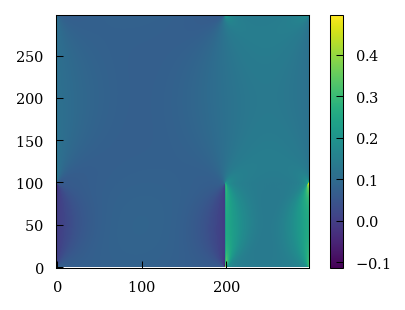

In [52]:
plt.imshow(final_state[2].at[0, 1].get(), origin="lower")
plt.colorbar()